In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(12345)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

In [2]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C09    452
C12    227
C01    212
C10    169
C13    165
C02    158
C04     99
C05     61
C06     46
C03     45
Name: count, dtype: int64

In [41]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 4

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)


In [42]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [43]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13'])

Initialize random model parameters and latent variables/responsibilities.

In [44]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}

mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [45]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [46]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif (np.isclose(current_likelihood, likelihood_history[-steps_back - 1],rtol = 0, atol = 0.001)) and np.all(current_likelihood <= np.array(likelihood_history)):
            print('stopped due to likelihood similarity')
            return True
    return False

In [47]:
is_converged = False
count = 0
params_history = []
likelihood_history = []
params_history.append(params.copy())
likelihood_history.append(mixture.likelihood(use_complete=False))
# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    print(likelihood_history[-1])
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood(use_complete=False))
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    count += 1

0
-8801.01838948282
1
-3416.5258637644856
2
-3348.695346431136
3
-3314.438023799672
4
-3294.071704988498
5
-3280.8755742317558
6
-3271.883846929119
7
-3264.7179599947367
8
-3258.595486580222
9
-3253.206225765738
10
-3248.4573531017213
11
-3244.31117314214
12
-3240.7531644910555
13
-3237.746203788932
14
-3235.2332409620594
15
-3233.125730205218
16
-3231.3335661260935
17
-3229.809209464528
18
-3228.46157405311
19
-3227.256693419846
20
-3226.1533336608195
21
-3225.1054785351043
22
-3224.0929470903407
23
-3223.103717632861
24
-3222.1276623596505
25
-3221.1614611510336
26
-3220.2066924580877
27
-3219.260480822291
28
-3218.327776480361
29
-3217.407435412528
30
-3216.5045214978127
31
-3215.62029569444
32
-3214.748957943014
33
-3214.010505774975
34
-3213.2710457714875
35
-3212.37339242318
36
-3211.4372072877236
37
-3210.4655662471846
38
-3209.430530027128
39
-3208.355413572549
40
-3207.25022131055
41
-3206.130283131608
42
-3205.0281803775047
43
-3204.014451077583
44
-3203.1089967491016
45
-320

KeyboardInterrupt: 

In [48]:
a = np.array(likelihood_history)
np.savetxt('likelihoods_3_comp_t_stage_new.txt', a, fmt='%.6f')
b = np.loadtxt('likelihoods_3_comp_t_stage_new.txt', dtype=float)
b


array([-8801.018389, -3416.525864, -3348.695346, -3314.438024,
       -3294.071705, -3280.875574, -3271.883847, -3264.71796 ,
       -3258.595487, -3253.206226, -3248.457353, -3244.311173,
       -3240.753164, -3237.746204, -3235.233241, -3233.12573 ,
       -3231.333566, -3229.809209, -3228.461574, -3227.256693,
       -3226.153334, -3225.105479, -3224.092947, -3223.103718,
       -3222.127662, -3221.161461, -3220.206692, -3219.260481,
       -3218.327776, -3217.407435, -3216.504521, -3215.620296,
       -3214.748958, -3214.010506, -3213.271046, -3212.373392,
       -3211.437207, -3210.465566, -3209.43053 , -3208.355414,
       -3207.250221, -3206.130283, -3205.02818 , -3204.014451,
       -3203.108997, -3202.324913, -3201.603154, -3200.953051,
       -3200.361053, -3199.824256, -3199.339697, -3198.899602,
       -3198.506374, -3198.155494, -3197.838805, -3197.558902,
       -3197.305872, -3197.078043, -3196.868691, -3196.678806,
       -3196.507307, -3196.349274, -3196.203258, -3196.

In [49]:
differences = []
for i in range(len(params_history)-1):
    differences.append(np.abs(np.array(list(params_history[i].values())) - np.array(list(params_history[i+1].values()))).sum())
differences

[26.138367038482485,
 3.07660859911005,
 1.6988008733053928,
 1.215017102273209,
 0.9679045556458823,
 0.757101393676539,
 0.6847745605513651,
 0.6339665258567855,
 0.6008296567184725,
 0.5659782531031413,
 0.5267575232052613,
 0.47850235150668236,
 0.4223317243907262,
 0.3397669024002549,
 0.2901272128782345,
 0.26063964090754727,
 0.2512307518655493,
 0.2545549816167441,
 0.3060027975565701,
 0.3187471756871916,
 0.3181787189553341,
 0.3115039545720999,
 0.3031367020002174,
 0.29503955324413644,
 0.2892122358433936,
 0.28354669612589023,
 0.27720436888023825,
 0.27177978485838405,
 0.26552337975478124,
 0.2653285492692139,
 0.26399738348457313,
 0.26300860183138947,
 0.18087030269309579,
 0.15352917445513042,
 0.20045464479721792,
 0.20375961473514614,
 0.2206924350214362,
 0.23387271241304874,
 0.24611152032896816,
 0.25340994912807113,
 0.2610044686033563,
 0.26972199606002645,
 0.25978418312598883,
 0.2678314355727369,
 0.2855964719082558,
 0.3350485635764685,
 0.11122739089599819

Text(0.5, 1.0, 'Convergence of EM algorithm 3 comp 3 locs')

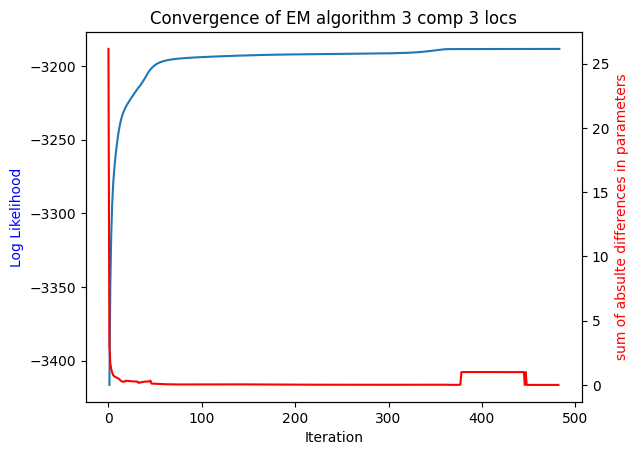

In [50]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(np.array(range(len(likelihood_history[1:])))+1,likelihood_history[1:])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log Likelihood', color='blue')
ax2 = ax1.twinx()
ax2.plot(differences, color='red')  
ax2.set_ylabel('sum of absulte differences in parameters', color='red')
ax1.set_title('Convergence of EM algorithm 3 comp 3 locs')

In [51]:
params = params_history[np.argmax(likelihood_history)]
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [52]:
mixture.likelihood(use_complete=False)

-3188.4030216791466

In [53]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.002232,0.010554,2.514139e-93,0.001747,0.013084,6.743400e-04,0.044828,0.105814,7.016317e-01,5.400773e-01
1,0.036851,0.418110,1.000000e+00,0.703681,0.394382,9.646098e-01,0.063951,0.096926,1.069412e-15,8.050579e-16
2,0.756236,0.166833,2.431020e-99,0.000044,0.286901,3.471589e-02,0.614616,0.353831,1.148394e-04,1.031969e-03
3,0.204681,0.404503,1.819048e-14,0.294529,0.305633,4.867811e-15,0.276606,0.443428,2.982535e-01,4.588908e-01


In [54]:
mixture.get_params()

{'0_TtoI_spread': 0.02155770513421649,
 '0_TtoII_spread': 0.46774960876206334,
 '0_TtoIII_spread': 0.40607497825033223,
 '0_TtoIV_spread': 0.11333518315546852,
 '0_TtoV_spread': 0.03799167287158265,
 '0_ItoII_spread': 0.0028208101061453447,
 '0_IItoIII_spread': 6.610696135189607e-05,
 '0_IIItoIV_spread': 6.610696135189607e-05,
 '0_IVtoV_spread': 0.1259022571532193,
 '0_late_p': 0.3128575680731565,
 '0_C01_coef': 0.002231541947948199,
 '0_C02_coef': 0.010554327243122585,
 '0_C03_coef': 2.5141386012050302e-93,
 '0_C04_coef': 0.0017468731735837597,
 '0_C05_coef': 0.013084302344718924,
 '0_C06_coef': 0.0006743399650368525,
 '0_C09_coef': 0.04482751925163307,
 '0_C10_coef': 0.10581440362470551,
 '0_C12_coef': 0.701631678712359,
 '0_C13_coef': 0.5400772793036543,
 '1_TtoI_spread': 0.08598609650586277,
 '1_TtoII_spread': 0.023297078118953648,
 '1_TtoIII_spread': 0.013419067386810897,
 '1_TtoIV_spread': 0.0025456701868664527,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.168959

In [55]:
subgroup = 'C13'
t_stage = 'late'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV','V'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None, 'V': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/((mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage) & (np.all(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].notna(),axis = 1))).sum().sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

(df_final*100)

II prevalence    70.175439
dtype: float64
predicted involvement of II 64.99828445302559


,prevalence,predicted,difference
[0 0 0 0 0],16.666667,20.394168,3.727501
[0 0 0 0 1],0.877193,1.449653,0.572460
[0 0 0 1 0],0.877193,1.543768,0.666575
[0 0 0 1 1],0.000000,0.169591,0.169591
[0 0 1 0 0],7.894737,8.443665,0.548928
[0 0 1 0 1],0.877193,0.744878,-0.132315
[0 0 1 1 0],2.631579,1.454908,-1.176671
[0 0 1 1 1],0.000000,0.337509,0.337509
[0 1 0 0 0],21.052632,20.405152,-0.647480
[0 1 0 0 1],1.754386,1.801514,0.047128


## Load/Save Data

In [56]:
import pickle 
from lymixture.em import expectation, maximization

with open('params_I_to_V_ipsi_4_comp_split_t_stages_new.pkl', 'wb') as f:
    pickle.dump(params, f)
        
# with open('params_I_to_V_ipsi_3_comp_split_t_stages_new.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)
# params = loaded_dict
# mixture.set_params(**loaded_dict)
# mixture.normalize_mixture_coefs()
# mixture.set_resps(expectation(mixture, loaded_dict))
# mixture.likelihood(use_complete= False)

In [57]:
mixture.likelihood(use_complete= True)


-4047.151822283971

In [58]:
# mixture.patient_mixture_likelihoods('early', True)
mixture.t_stages

['early', 'late']

In [59]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.002232,0.010554,2.514139e-93,0.001747,0.013084,6.743400e-04,0.044828,0.105814,7.016317e-01,5.400773e-01
1,0.036851,0.418110,1.000000e+00,0.703681,0.394382,9.646098e-01,0.063951,0.096926,1.069412e-15,8.050579e-16
2,0.756236,0.166833,2.431020e-99,0.000044,0.286901,3.471589e-02,0.614616,0.353831,1.148394e-04,1.031969e-03
3,0.204681,0.404503,1.819048e-14,0.294529,0.305633,4.867811e-15,0.276606,0.443428,2.982535e-01,4.588908e-01


## Mixture evaluation

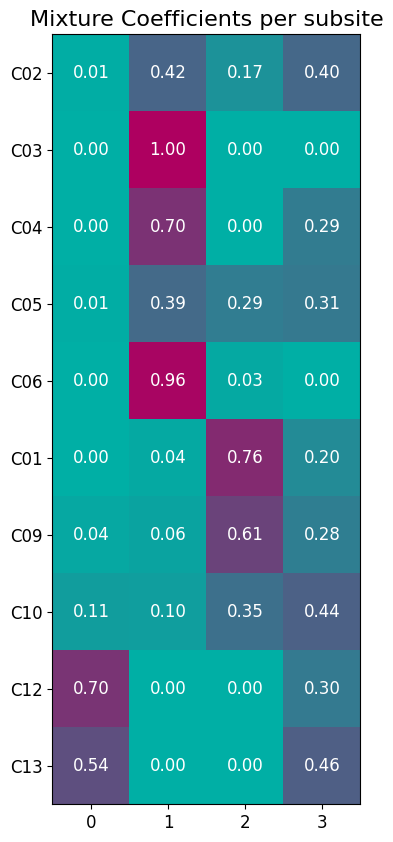

In [60]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()


In [186]:
params

{'0_TtoI_spread': 0.02196907557812769,
 '0_TtoII_spread': 0.7854884830280808,
 '0_TtoIII_spread': 0.04028762434419442,
 '0_TtoIV_spread': 0.006184703202382825,
 '0_TtoV_spread': 0.012609454889116346,
 '0_ItoII_spread': 0.9999338930386481,
 '0_IItoIII_spread': 0.01966598174892645,
 '0_IIItoIV_spread': 0.04060297853546493,
 '0_IVtoV_spread': 0.0318308057296282,
 '0_late_p': 0.743195855986679,
 '0_C01_coef': 0.6884070828106644,
 '0_C02_coef': 0.1460116709305345,
 '0_C03_coef': 6.610696135189607e-05,
 '0_C04_coef': 0.06294068445366022,
 '0_C05_coef': 0.2618900254228789,
 '0_C06_coef': 5.691151248208184e-05,
 '0_C09_coef': 0.5340747337667432,
 '0_C10_coef': 0.2954488757851111,
 '0_C12_coef': 0.00984081701962778,
 '0_C13_coef': 3.494763452767987e-05,
 '1_TtoI_spread': 0.06061474312619695,
 '1_TtoII_spread': 0.022899467868196476,
 '1_TtoIII_spread': 0.012759313853766285,
 '1_TtoIV_spread': 0.00277333117517059,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.17762029018261238,
 '

In [187]:
params_history

[{'0_TtoI_spread': 0.22733602246716966,
  '0_TtoII_spread': 0.31675833970975287,
  '0_TtoIII_spread': 0.7973654573327341,
  '0_TtoIV_spread': 0.6762546707509746,
  '0_TtoV_spread': 0.391109550601909,
  '0_ItoII_spread': 0.33281392786638453,
  '0_IItoIII_spread': 0.5983087535871898,
  '0_IIItoIV_spread': 0.18673418560371335,
  '0_IVtoV_spread': 0.6727560440146213,
  '0_late_p': 0.9418028652699372,
  '0_C01_coef': 0.248245714629571,
  '0_C02_coef': 0.9488811518333182,
  '0_C03_coef': 0.6672374531003724,
  '0_C04_coef': 0.09589793559411208,
  '0_C05_coef': 0.4418396661678128,
  '0_C06_coef': 0.8864799193275177,
  '0_C09_coef': 0.6974534998820221,
  '0_C10_coef': 0.3264728640701121,
  '0_C12_coef': 0.7339281633300665,
  '0_C13_coef': 0.22013495554548623,
  '1_TtoI_spread': 0.08159456954220812,
  '1_TtoII_spread': 0.15989560107504752,
  '1_TtoIII_spread': 0.3401001849547053,
  '1_TtoIV_spread': 0.46519315370205094,
  '1_TtoV_spread': 0.26642102829077097,
  '1_ItoII_spread': 0.81577640342480

2d Simplex plot

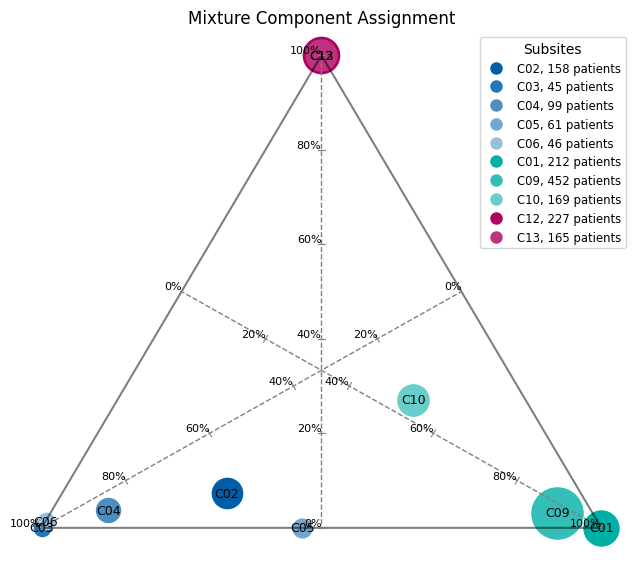

In [30]:
from matplotlib.lines import Line2D
# colormaps
blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)
colors_ordered= [blue_to_white(0), blue_to_white(0.15), blue_to_white(0.3), blue_to_white(0.45), blue_to_white(0.6), green_to_white(0), green_to_white(0.2), green_to_white(0.4), red_to_white(0), red_to_white(0.2)]  

# Define the plane's normal vector
normal_vector = np.array([1,1,1])/1/np.sqrt(3)

v1 = np.array([1,-1,0])/1/np.sqrt(2)

# Calculate the second orthogonal vector using the cross product
v2 = np.cross(normal_vector, v1) *-1

# Project the point onto the new coordinate system
origin = np.array([0, 1, 0])
x_origin =  origin @ v1
y_origin = origin @ v2

x_vals = matrix.T @ v1 - x_origin
y_vals = matrix.T @ v2 - y_origin

extremes = np.array([[1,0,0],
                    [0,1,0],
                    [0,0,1]])
extremes_x = extremes @ v1 - x_origin
extremes_y = extremes @ v2 - y_origin

# Plot the point in 2D
import matplotlib.pyplot as plt

odered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]
sizes = odered_value_counts * 3

# Define the subsite labels
subsites = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']
plt.figure(figsize=(8, 6.8))
# Plot the points with varying sizes and colors
for i in range(len(x_vals)):
    plt.scatter(x_vals[i], y_vals[i], s=sizes[i], color=colors_ordered[i], label=subsites[i])
    plt.text(x_vals[i], y_vals[i], subsites[i], fontsize=9, ha='center', va='center')

legend_text = []
for index in range(len(subsites)):
    legend_text.append(subsites[index] + ', ' + str(odered_value_counts[index]) + ' patients')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=subsite)
                   for color, subsite in zip(colors_ordered, legend_text)]

# Add a legend with fixed dot sizes
plt.legend(handles=legend_elements, loc='upper right', title='Subsites', fontsize='small')
# plt.scatter(x_vals, y_vals, s=sizes, c = colors_ordered)
# Connect the points
plt.plot(extremes_x, extremes_y, color='black', alpha = 0.5)
# close the triangle by connecting the last point to the first
plt.plot([extremes_x[-1], extremes_x[0]], [extremes_y[-1], extremes_y[0]], color='black', alpha = 0.5)

# Calculate midpoints of each side of the triangle
midpoints_x = (extremes_x[0] + extremes_x[1]) / 2, (extremes_x[1] + extremes_x[2]) / 2, (extremes_x[2] + extremes_x[0]) / 2
midpoints_y = (extremes_y[0] + extremes_y[1]) / 2, (extremes_y[1] + extremes_y[2]) / 2, (extremes_y[2] + extremes_y[0]) / 2

# Draw lines from each vertex to the midpoint of the opposite side
plt.plot([extremes_x[0], midpoints_x[1]], [extremes_y[0], midpoints_y[1]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[1], midpoints_x[2]], [extremes_y[1], midpoints_y[2]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[2], midpoints_x[0]], [extremes_y[2], midpoints_y[0]], color='gray', linestyle='--', linewidth=1)

# Function to add perpendicular ticks as short lines
def add_perpendicular_ticks(x1, y1, x2, y2, tick_length=0.01):
    num_ticks = 6  # Number of ticks including 0% and 100%
    for i in range(num_ticks):
        t = i / (num_ticks - 1)
        x_tick = x1 + t * (x2 - x1)
        y_tick = y1 + t * (y2 - y1)
        
        # Vector along the line
        dx = x2 - x1
        dy = y2 - y1
        
        # Perpendicular vector
        perp_dx = -dy
        perp_dy = dx
        
        # Normalize the perpendicular vector
        length = np.sqrt(perp_dx**2 + perp_dy**2)
        perp_dx /= length
        perp_dy /= length
        
        # Draw tick as a short perpendicular line
        plt.plot([x_tick - tick_length * perp_dx, x_tick + tick_length * perp_dx], [y_tick - tick_length * perp_dy, y_tick + tick_length * perp_dy], color='gray', linewidth=0.8)
        plt.text(x_tick, y_tick, f'{int(100 - t * 100)}%', fontsize=8, ha='right', va='bottom')

# Add perpendicular ticks to each line with adjusted length
add_perpendicular_ticks(extremes_x[0], extremes_y[0], midpoints_x[1], midpoints_y[1])
add_perpendicular_ticks(extremes_x[1], extremes_y[1], midpoints_x[2], midpoints_y[2])
add_perpendicular_ticks(extremes_x[2], extremes_y[2], midpoints_x[0], midpoints_y[0])



plt.xlabel('u')
plt.ylabel('v')
plt.title('Mixture Component Assignment')
plt.gca().set_axis_off()

plt.show()

In [31]:


legend_text

['C02, 158 patients',
 'C03, 45 patients',
 'C04, 99 patients',
 'C05, 61 patients',
 'C06, 46 patients',
 'C01, 212 patients',
 'C09, 452 patients',
 'C10, 169 patients',
 'C12, 227 patients',
 'C13, 165 patients']